In [245]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.circuit import Parameter
import numpy as np
from qiskit.quantum_info import Pauli, SparsePauliOp, DensityMatrix
from qiskit.circuit.library import RealAmplitudes
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix, state_fidelity, Statevector
from qiskit_algorithms.optimizers import GradientDescent


In [246]:
# Define Estimator and sampler 
estimator = StatevectorEstimator()
sampler = StatevectorSampler()



In [247]:


# Define the number of qubits
num_wires = 2
# wires = list(range(num_wires))
# np.random.seed(62213)

# Generate random coefficients for the Pauli basis
coefficients = np.random.randn(4**num_wires - 1)

# Define the Pauli basis for the given number of qubits
pauli_basis = []
for i in range(1, 4**num_wires):  # Skip the identity (first element)
    pauli_str = np.base_repr(i, base=4).zfill(num_wires)
    pauli_str = pauli_str.replace('0', 'I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    pauli_basis.append(pauli_str)

# Construct the A matrix using SparsePauliOp
A_matrix = SparsePauliOp(pauli_basis, coefficients)

Q, R = np.linalg.qr(A_matrix)  # QR decomposition

Q

# Define the B vector
B = np.array([0, 0, 0, 1])

# # Compute the density matrix of B
# rho_b = DensityMatrix.from_label('00')  # |00⟩ corresponds to [1, 0, 0, 0]

# # Print results
# print("A matrix (SparsePauliOp):\n", Q)
# print("\nDensity matrix of B:\n", rho_b)



In [248]:
init_param = np.random.rand(15)
init_param

array([0.00919705, 0.10147154, 0.66350177, 0.00506158, 0.16080805,
       0.54873379, 0.6918952 , 0.65196126, 0.22426931, 0.71217922,
       0.23724909, 0.3253997 , 0.74649141, 0.6496329 , 0.84922341])

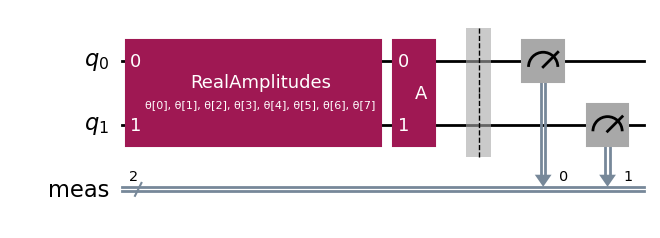

In [249]:
ansatz = RealAmplitudes(num_wires, reps=3)

# define a quantum circuit with 2 qubits that takes A_matrix as a unitary operator and 01 as the initial state 
qc = QuantumCircuit(2)
# qc.x(1)

# add ansatz to the circuit
qc.compose(ansatz, inplace=True)
qc.unitary(Q, [0, 1], label='A')
qc.measure_all()
qc.draw('mpl')




In [250]:

def cost_function(params):
    # Bind parameters to the ansatz
    job_sampler = sampler.run([(qc,params)], shots=1000)
    result = job_sampler.result()
    counts = result[0].data.meas.get_counts()
    # Extract counts for each basis state in the order |00>, |01>, |10>, |11>
    counts_ordered = [counts.get('00', 0), counts.get('01', 0), counts.get('10', 0), counts.get('11', 0)]

    # Take the square root of each count
    sqrt_counts = np.sqrt(counts_ordered)

    # Normalize the statevector
    normalization_factor = np.linalg.norm(sqrt_counts)
    statevector = sqrt_counts / normalization_factor

    X = DensityMatrix(statevector)  # Density matrix of |01⟩
    # DensityMatrix()
    # Compute the fidelity between X and rho_b
    fidelity = 1- state_fidelity(statevector, B)
    
    # Return the cost as 1 - fidelity
    return fidelity

In [251]:
# Choose random initial parameters
init_params = np.random.rand(ansatz.num_parameters)

# Compute the cost
# cost_value = cost_function(initial_params)
# print("Initial parameters:", initial_params)
# print("Cost value:", cost_value)

In [252]:
cost_function(init_params)

0.761

In [253]:
n_iterations = 50000# Optimize using COBYLA
result = minimize(
    cost_function,  # Cost function to minimize
    init_params,  # Initial parameters
    method='COBYLA',  # Optimization method
    options={'maxiter': n_iterations}  # Number of iterations
)

# Print the optimization results
print("Optimization results:")
print("Optimal parameters:", result.x)
print("Minimum cost value:", result.fun)


# job_sampler = sampler.run([(qc,result.x)], shots=1000)
# result = job_sampler.result()
# counts = result[0].data.meas.get_counts()
# counts

Optimization results:
Optimal parameters: [1.67766982 0.98175073 0.33146019 1.42293836 0.19132197 0.1429377
 2.00994191 1.43864228]
Minimum cost value: 0.15900000000000003


In [254]:
def state(params):
    # Bind parameters to the ansatz
    job_sampler = sampler.run([(qc,params)], shots=1000)
    result = job_sampler.result()
    counts = result[0].data.meas.get_counts()
    # Extract counts for each basis state in the order |00>, |01>, |10>, |11>
    counts_ordered = [counts.get('00', 0), counts.get('01', 0), counts.get('10', 0), counts.get('11', 0)]

    # Take the square root of each count
    sqrt_counts = np.sqrt(counts_ordered)

    # Normalize the statevector
    normalization_factor = np.linalg.norm(sqrt_counts)
    statevector = sqrt_counts / normalization_factor

    return statevector

In [255]:
state(result.x)

array([0.19493589, 0.15491933, 0.28809721, 0.9246621 ])